In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
from scipy import optimize

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 18})

from functools import reduce
from collections import OrderedDict

from torch.distributions.normal import Normal
from torch.distributions.gumbel import Gumbel

from WassersteinDistance import OneDimMonotoneWasserstein, OneDimEmpWasserstein
from PolyModel import HermitePolyModel, HermiteFunctionModel

# convert to double
torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
class PyTorchObjective(object):
    """PyTorch objective function, wrapped to be called by scipy.optimize."""
    def __init__(self, obj_module):
        self.f = obj_module # some pytorch module, that produces a scalar loss
        # make an x0 from the parameters in this module
        parameters = OrderedDict(obj_module.named_parameters())
        self.param_shapes = {n:parameters[n].size() for n in parameters}
        # ravel and concatenate all parameters to make x0
        self.x0 = np.concatenate([parameters[n].data.numpy().ravel() 
                                   for n in parameters])

    def unpack_parameters(self, x):
        """optimize.minimize will supply 1D array, chop it up for each parameter."""
        i = 0
        named_parameters = OrderedDict()
        for n in self.param_shapes:
            param_len = reduce(lambda x,y: x*y, self.param_shapes[n])
            # slice out a section of this length
            param = x[i:i+param_len]
            # reshape according to this size, and cast to torch
            param = param.reshape(*self.param_shapes[n])
            named_parameters[n] = torch.from_numpy(param)
            # update index
            i += param_len
        return named_parameters

    def pack_grads(self):
        """pack all the gradients from the parameters in the module into a
        numpy array."""
        grads = []
        for p in self.f.parameters():
            grad = p.grad.data.numpy()
            grads.append(grad.ravel())
        return np.concatenate(grads)

    def is_new(self, x):
        # if this is the first thing we've seen
        if not hasattr(self, 'cached_x'):
            return True
        else:
            # compare x to cached_x to determine if we've been given a new input
            x, self.cached_x = np.array(x), np.array(self.cached_x)
            error = np.abs(x - self.cached_x)
            return error.max() > 1e-14

    def cache(self, x):
        # unpack x and load into module 
        state_dict = self.unpack_parameters(x)
        self.f.load_state_dict(state_dict)
        # store the raw array as well
        self.cached_x = x
        # zero the gradient
        self.f.zero_grad()
        # use it to calculate the objective
        obj = self.f()
        # backprop the objective
        obj.backward()
        self.cached_f = obj.item()
        self.cached_jac = self.pack_grads()

    def fun(self, x):
        if self.is_new(x):
            self.cache(x)
        return self.cached_f

    def jac(self, x):
        if self.is_new(x):
            self.cache(x)
        return self.cached_jac


### Test optimization

Wp distance: 0.004444


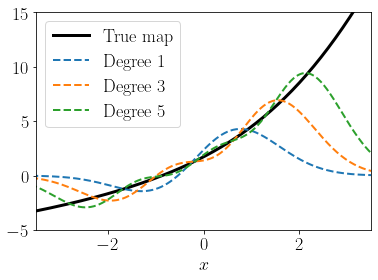

In [3]:
np.random.seed(1)
torch.manual_seed(1)

# define model
order = 10
dx = 1
F = HermitePolyModel(order)

# define reference
eta = Normal(torch.tensor([0.0]), torch.tensor([1.0]))

# define target density
from torch.distributions.gumbel import Gumbel
nu = Gumbel(torch.tensor([1.0]), torch.tensor([2.0]))

# define and optimize objective
N = 100
p = 2
objective = OneDimMonotoneWasserstein(nu, F, eta, N, p)
if p == 2:
    objective.optimize()
else:
    obj = PyTorchObjective(objective)
    xL = optimize.minimize(obj.fun, obj.x0, method='BFGS', jac=obj.jac,
            options={'gtol':1e-4,'disp':True,'maxiter':500})
    objective.T2.linear.weight.data = torch.tensor(xL.x)[None,:]
print('Wp distance: %f' % objective.forward()**(1./p))

# plot the approximate map and monotone map
xx = torch.linspace(-6,6,400).double()#.view(-1,1)
Ttrue_xx = nu.icdf(eta.cdf(xx)).numpy()
Tapprox_xx = F(xx)[:,0].detach().numpy()

plt.figure()
plt.plot(xx, Ttrue_xx, linewidth=3, linestyle='-', color='k', label='True map')
for order in [1,3,5]:
    # define model
    F = HermiteFunctionModel(order)
    # define objective
    objective = OneDimMonotoneWasserstein(nu, F, eta, N, p)
    # optimize objective
    if p==2:
        objective.optimize()
    else:
        obj = PyTorchObjective(objective)
        xL = optimize.minimize(obj.fun, obj.x0, method='BFGS', jac=obj.jac,
                options={'gtol':1e-4,'disp':True,'maxiter':500})
        objective.T2.linear.weight.data = torch.tensor(xL.x)[None,:]
    # plot approximate map
    Tapprox_xx = F(xx)[:,0].detach().numpy()
    plt.plot(xx, Tapprox_xx, linewidth=2, linestyle='--', label='Degree '+str(order))
plt.xlim(-3.5,3.5)
plt.ylim(-5,15)
plt.xlabel('$x$')
plt.legend()
plt.savefig('figures/Wasserstein2_Gumbel_map.pdf', bbox_inches="tight")

### Convergence of map

In [4]:
# generate test points using batches
Ntest         = 1000000
batches       = 10
xtest = []
for i in range(batches):
    xtest.append(eta.sample((Ntest,)))
xtest = torch.cat(xtest)

# evaluate true map at test points
Ttrue_xx = nu.icdf(eta.cdf(xtest))
print(Ttrue_xx.shape)

torch.Size([10000000, 1])


In [14]:
Ntrain        = 10000
Nmon          = 10000
pvect         = [1,2]
orders        = np.linspace(0,20,21,dtype=int)
Wp_loss       = np.zeros((len(pvect), len(orders)))
Wp_emp        = np.zeros((len(pvect), len(orders)))
Lp_err        = np.zeros((len(pvect), len(orders)))
mon_percent   = np.zeros((len(pvect), len(orders)))

# define reference and test points
eta = Normal(torch.tensor([0.0]), torch.tensor([1.0]))

# define two sets of test points to check monotonicity
xtest_p1 = eta.sample((Nmon,))
xtest_p2 = eta.sample((Nmon,))

# define objective for computing distance
Wp_check = OneDimEmpWasserstein(N=2*Ntrain)

# run map optimization
for (j,p) in enumerate(pvect):
    for (i,order) in enumerate(orders):

        print('p = %d, order = %d' % (p, order))

        # define model
        T = HermiteFunctionModel(order)

        # define and minimize objective
        objective = OneDimMonotoneWasserstein(nu, T, eta, N=Ntrain, p=p)
        if p == 2:
            objective.optimize()
        else:
            obj = PyTorchObjective(objective)
            xL = optimize.minimize(obj.fun, obj.x0, method='BFGS', jac=obj.jac,
                   options={'gtol': 1e-4,'disp':False,'maxiter':500})
            objective.T.linear.weight.data = torch.tensor(xL.x)[None,:]

        # evaluate map
        T.eval()
        Tx = T(xtest[:,0])

        # measure map error and monotonicity
        Wp_loss[j,i]       = objective.forward()
        Wp_emp[j,i]        = Wp_check.forward(nu, Tx, p)
        Lp_err[j,i]        = ((Ttrue_xx - Tx).pow(p).mean().item())**(1./p)
        mon_percent[j,i]   = torch.mean(((T(xtest_p1[:,0]) - T(xtest_p2[:,0])) * (xtest_p1 - xtest_p2) > 0.0)*1.0).item()        

p = 1, order = 0
p = 1, order = 1
p = 1, order = 2
p = 1, order = 3
p = 1, order = 4
p = 1, order = 5
p = 1, order = 6
p = 1, order = 7
p = 1, order = 8
p = 1, order = 9
p = 1, order = 10
p = 1, order = 11
p = 1, order = 12
p = 1, order = 13
p = 1, order = 14
p = 1, order = 15
p = 1, order = 16
p = 1, order = 17
p = 1, order = 18
p = 1, order = 19
p = 1, order = 20
p = 2, order = 0
p = 2, order = 1
p = 2, order = 2
p = 2, order = 3
p = 2, order = 4
p = 2, order = 5
p = 2, order = 6
p = 2, order = 7
p = 2, order = 8
p = 2, order = 9
p = 2, order = 10
p = 2, order = 11
p = 2, order = 12
p = 2, order = 13
p = 2, order = 14
p = 2, order = 15
p = 2, order = 16
p = 2, order = 17
p = 2, order = 18
p = 2, order = 19
p = 2, order = 20


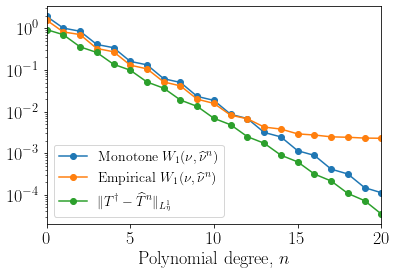

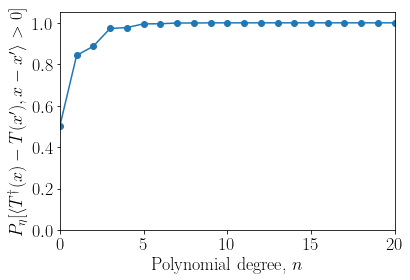

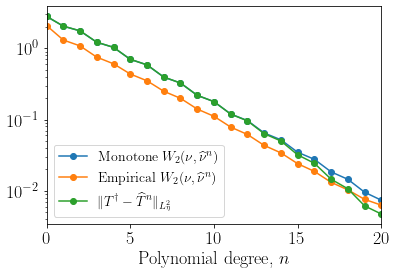

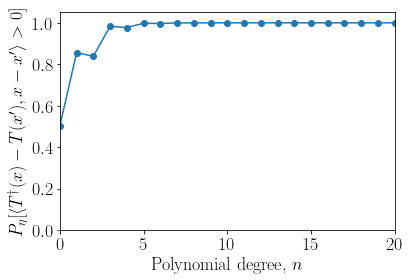

In [16]:
for (j,p) in enumerate(pvect):
    plt.figure()
    plt.semilogy(orders, Wp_loss[j,:], '-o', label='Monotone $W_'+str(p)+'(\\nu,\widehat{\\nu}^n)$')
    plt.semilogy(orders, Wp_emp[j,:], '-o', label='Empirical $W_'+str(p)+'(\\nu,\widehat{\\nu}^n)$')
    plt.semilogy(orders, Lp_err[j,:], '-o', label='$\|T^\dagger - \widehat{T}^n\|_{L^'+str(p)+'_\eta}$')
    plt.xlabel('Polynomial degree, $n$')
    plt.xlim(0,max(orders))
    plt.legend(loc='lower left',fontsize=14)
    plt.savefig('figures/W'+str(p)+'gumbel_Wass_L2.pdf',bbox_inches="tight")

    plt.figure()
    plt.plot(orders, mon_percent[j,:], '-o')
    plt.xlabel('Polynomial degree, $n$')
    plt.ylabel('$P_\eta[\\langle T^\dagger(x) - T(x\'), x - x\' \\rangle > 0]$')
    plt.xlim(0,max(orders))
    plt.ylim(0,1.05)
    plt.savefig('figures/W'+str(p)+'gumbel_monotonicity.pdf',bbox_inches="tight")

In [15]:
# create table with results
for (j,p) in enumerate(pvect):
    print('p = '+str(p))
    for (i,order) in enumerate(orders):
        print('$'+str(order), end ="$ & ")
    print('\\\\')
    print('$W_2(\pi,\hat\pi)$', end=' & ')
    for (i,order) in enumerate(orders):
        print('$ %1.2e' % (Wp_loss[j,i]), end ="$ & ")
    print('\\\\')
    print('$\|T - \hat T\|_{L^2_\eta}$', end=' & ')
    for (i,order) in enumerate(orders):
        print('$ %1.2e' % (Lp_err[j,i]), end ="$ & ")
    print('\\\\')
    print('Percent monotone', end=' & ')
    for (i,order) in enumerate(orders):
        print('$ %1.2e' % (mon_percent[j,i]), end ="$ & ")
    print('\\\\')

p = 1
$0$ & $1$ & $2$ & $3$ & $4$ & $5$ & $6$ & $7$ & $8$ & $9$ & $10$ & $11$ & $12$ & $13$ & $14$ & $15$ & $16$ & $17$ & $18$ & $19$ & $20$ & \\
$W_2(\pi,\hat\pi)$ & $ 1.94e+00$ & $ 1.01e+00$ & $ 8.50e-01$ & $ 4.09e-01$ & $ 3.43e-01$ & $ 1.61e-01$ & $ 1.33e-01$ & $ 6.15e-02$ & $ 5.01e-02$ & $ 2.32e-02$ & $ 1.86e-02$ & $ 8.60e-03$ & $ 6.81e-03$ & $ 3.16e-03$ & $ 2.47e-03$ & $ 1.15e-03$ & $ 8.89e-04$ & $ 4.16e-04$ & $ 3.18e-04$ & $ 1.49e-04$ & $ 1.13e-04$ & \\
$\|T - \hat T\|_{L^2_\eta}$ & $ 9.31e-01$ & $ 7.02e-01$ & $ 3.59e-01$ & $ 2.63e-01$ & $ 1.37e-01$ & $ 9.87e-02$ & $ 5.14e-02$ & $ 3.65e-02$ & $ 1.89e-02$ & $ 1.33e-02$ & $ 6.89e-03$ & $ 4.82e-03$ & $ 2.50e-03$ & $ 1.74e-03$ & $ 8.99e-04$ & $ 6.21e-04$ & $ 3.17e-04$ & $ 2.16e-04$ & $ 1.08e-04$ & $ 7.27e-05$ & $ 3.48e-05$ & \\
Percent monotone & $ 5.03e-01$ & $ 8.43e-01$ & $ 8.87e-01$ & $ 9.73e-01$ & $ 9.77e-01$ & $ 9.95e-01$ & $ 9.96e-01$ & $ 9.99e-01$ & $ 9.99e-01$ & $ 1.00e+00$ & $ 1.00e+00$ & $ 1.00e+00$ & $ 1.00e+00$ & $ 1.00e+